# Spectral analysis

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

import drifters.utils as ut
import pynsitu as pin
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

%matplotlib inline
from matplotlib import pyplot as plt

import GDP_lib as gdp

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    w = cluster.scale(jobs=2)  # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.65:8787/status,
Dashboard: http://10.148.1.65:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.65:37897,Workers: 0
Dashboard: http://10.148.1.65:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
df, ds = gdp.noise_traj(5e-4)

In [7]:
df.y.mean().compute()

-0.012221531809879857

In [11]:
df

,date,nlon,nlat,lon,lat,noise_std,id,x,y,vx,vy,vxy,ax,ay,axy,time
npartitions=2,,,,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
500000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999999,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
ds.attrs["noise_std"]

0.0005

In [14]:
root_dir = "/home1/datawork/mdemol/GDP"
parquet_noise = os.path.join(root_dir, f"noise_{ds.attrs['noise_std']}_av_time.parquet")
zarr_noise = os.path.join(root_dir, f"noise_{ds.attrs['noise_std']}_spectra.zarr")

df.to_parquet(parquet_noise, engine="pyarrow", overwrite=True)
ds.to_zarr(zarr_noise, mode="w")

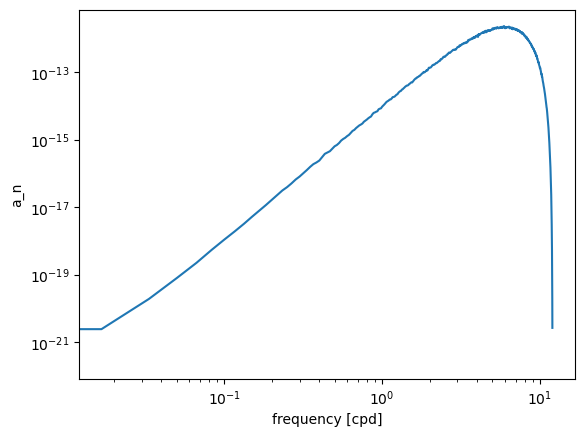

In [9]:
ds.a_n.plot()
plt.xscale("log")
plt.yscale("log")

#
___
#
___
#
___

____
# Computing

In [59]:
# CREATE NOISE
noise_std = 5e-4
time_unit = pd.Timedelta("1H")
t_ref = pd.Timestamp(2000, 1, 1)
t_size = 1e6
t = pd.date_range(t_ref, periods=t_size, freq=time_unit)
lon_ref = 0
lat_ref = 30
D = []


def white_noise_time_series(t, noise_std, lon_ref=0, lat_ref=45):
    draw = 2  # x, y
    da = ts.normal(time=t, draws=draw) * noise_std
    nlon = da.isel(draw=0).rename("nlon").drop("draw")
    nlat = da.isel(draw=1).rename("nlat").drop("draw")
    nlon[0] = 0  # centering
    nlat[0] = 0
    lon = (nlon / np.cos(lat_ref) + lon_ref).rename("lon")
    lat = (nlat + lat_ref).rename("lat")
    ds = xr.merge([nlon, nlat, lon, lat])
    ds["noise_std"] = noise_std
    ds["id"] = 0
    ds.attrs = {"description": f"white noise with std={noise_std}"}
    df = ds.to_dataframe()

    # add time in hours
    # df = df.reset_index().rename(columns={"time": "date"})
    # df["time"] = (df["date"] - t_ref) / time_unit
    # df = df.set_index('time')

    # add x, y , velocity and acceleration noise
    # INDEX TIME ?
    if not df.index.name == "time":
        warnings.warn("Are you sure time is the index ? ", UserWarning)
    # SORTED TIME ?
    if not df.index.is_monotonic_increasing:
        warnings.warn("time sorting dataframe", UserWarning)
        df.sort_index()

    _geo = pin.geo.GeoAccessor(df)
    _geo.compute_velocities(
        centered=True,
        names=(
            "vx",
            "vy",
            "vxy",
        ),
        inplace=True,
    )
    print(df.columns)
    _geo.compute_accelerations(
        names=("ax", "ay", "axy"),
        from_=("velocities", "vx", "vy"),
        centered_velocity=True,
        inplace=True,
    )
    print(df.columns)

    return _geo._obj


df = white_noise_time_series(t, noise_std, lon_ref, lat_ref)
df

Index(['nlon', 'nlat', 'lon', 'lat', 'noise_std', 'id', 'x', 'y', 'vx', 'vy',
       'vxy'],
      dtype='object')
Index(['nlon', 'nlat', 'lon', 'lat', 'noise_std', 'id', 'x', 'y', 'vx', 'vy',
       'vxy', 'ax', 'ay', 'axy'],
      dtype='object')


,nlon,nlat,lon,lat,noise_std,id,x,y,vx,vy,vxy,ax,ay,axy
time,,,,,,,,,,,,,,
2000-01-01 00:00:00,0.000000,0.000000,0.000000,30.000000,0.0005,0,0.000000,0.000000,0.078353,-0.076473,0.109487,-1.353438e-06,1.355354e-05,0.000014
2000-01-01 01:00:00,0.000348,-0.000114,-0.000592,29.999214,0.0005,0,-57.100872,-87.103967,-0.062969,0.001943,0.062999,-1.353438e-06,1.355354e-05,0.000014
2000-01-01 02:00:00,0.000161,0.000103,-0.004699,30.000126,0.0005,0,-453.373570,13.993241,0.068608,0.021112,0.071783,2.285907e-05,-1.027696e-06,0.000023
2000-01-01 03:00:00,0.000137,0.000232,0.004528,30.000585,0.0005,0,436.882474,64.870879,0.101617,-0.005456,0.101763,-2.386376e-05,-5.715252e-06,0.000025
2000-01-01 04:00:00,-0.000591,0.000759,0.002884,29.999771,0.0005,0,278.272331,-25.334089,-0.103211,-0.020037,0.105138,-3.368836e-06,2.937531e-06,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114-01-29 11:00:00,0.000044,-0.000564,-0.001291,30.000792,0.0005,0,-124.538429,87.784358,0.007521,-0.001283,0.007630,1.560412e-05,-2.460665e-06,0.000016
2114-01-29 12:00:00,0.000692,-0.000263,0.001581,29.999671,0.0005,0,152.534992,-36.507065,0.028496,-0.020631,0.035180,-4.319280e-06,-2.745585e-07,0.000004
2114-01-29 13:00:00,-0.000331,0.000316,0.000836,29.999452,0.0005,0,80.630171,-60.761784,-0.023578,-0.003260,0.023802,3.009353e-07,4.873558e-06,0.000005


____
# Spectra

In [86]:
root_dir = "/home1/datawork/mdemol/GDP"
parquet_noise = os.path.join(root_dir, f"noise_{noise_std}_av_time.parquet")
df = dd.read_parquet(parquet_noise)

df = df.reset_index().rename(columns={"time": "date"})

# add time in hours
time_unit = pd.Timedelta("1H")
t_ref = pd.Timestamp(2000, 1, 1)
df["time"] = (df["date"] - t_ref) / time_unit
df.head()

,date,nlon,nlat,lon,lat,noise_std,id,x,y,vx,vy,vxy,ax,ay,axy,time
0,2000-01-01 00:00:00,0.000000,0.000000,0.000000,30.000000,0.0005,0,0.000000,0.000000,0.078353,-0.076473,0.109487,-0.000001,0.000014,0.000014,0.0
1,2000-01-01 01:00:00,0.000348,-0.000114,-0.000592,29.999214,0.0005,0,-57.100872,-87.103967,-0.062969,0.001943,0.062999,-0.000001,0.000014,0.000014,1.0
2,2000-01-01 02:00:00,0.000161,0.000103,-0.004699,30.000126,0.0005,0,-453.373570,13.993241,0.068608,0.021112,0.071783,0.000023,-0.000001,0.000023,2.0
3,2000-01-01 03:00:00,0.000137,0.000232,0.004528,30.000585,0.0005,0,436.882474,64.870879,0.101617,-0.005456,0.101763,-0.000024,-0.000006,0.000025,3.0
4,2000-01-01 04:00:00,-0.000591,0.000759,0.002884,29.999771,0.0005,0,278.272331,-25.334089,-0.103211,-0.020037,0.105138,-0.000003,0.000003,0.000004,4.0


In [170]:
T_str = "60D"  # days
dt = "1H"  # sampling

N = int(pd.Timedelta(T_str) / pd.Timedelta(dt))  # output size
T = pd.Timedelta(T_str) / time_unit  # must be in the same units than time

columns = [
    "lon",
    "lat",
]

Columns = {
    "n": columns + ["x", "y"],
    "v_n": columns + ["vx", "vy"],
    "a_n": columns + ["ax", "ay"],
}

In [171]:
def process_uv(lon, lat, u, v, N, dt, **kwargs):
    """Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled

    Parameters:
    -----------
        u, v: pd.Series
            zonal, meridional index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    """
    if lon is None:
        uv = None
    else:
        uv = u + 1j * v
    return pin.tseries.get_spectrum(uv, N, dt=dt, **kwargs)

In [172]:
# pin.drifters.
group = tuple(df.get_partition(0)["id"].loc[0].values.compute())[0]
dfg = df.groupby("id").get_group(group).compute()

meta = pin.drifters.time_window_processing(
    dfg, process_uv, columns + ["x", "y"], T, N, id_label="id", dt=dt, geo=True
)
# dfg.set_index("time").plot(x="lon", y="lat")


Df_chunked = {}
for l in Columns:
    df_chunked = (
        df.groupby("id")
        .apply(
            pin.drifters.time_window_processing,
            process_uv,
            Columns[l],
            T,
            N,
            id_label="id",
            dt=dt,
            geo=True,
            meta=meta,
        )
        .persist()
    )
    # recompute date
    df_chunked["date"] = t_ref + df_chunked.index * time_unit
    # rename x/y
    df_chunked = df_chunked.rename(columns=dict(x="lon", y="lat"))
    # add nrj
    # df_chunked['ven2'] = df.ve**2 +df.vn**2

    Df_chunked[l] = df_chunked.drop(columns=["date", "id", "lon", "lat"])

In [173]:
len(df_chunked)

1387

In [178]:
D = []
for l in Df_chunked:
    d = Df_chunked[l].mean(axis=0).compute()
    d = (
        d.reindex(d.index.astype("float"))
        .to_xarray()
        .rename({"index": "frequency"})
        .rename(l)
        .sortby("frequency")
    )
    D.append(d)
ds = xr.merge(list(Df_chunked.values()))
# .compute()).to_xarray().rename({'index':'frequency'})
ds.frequency.attrs = {"long_name": "frequency", "units": "cpd"}
ds.attrs = {"lon": lon_ref, "lat": lat_ref, "noise_std": noise_std}

In [179]:
ds

<xarray.Dataset>
Dimensions:    (frequency: 1440)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
Data variables:
    n          (frequency) float64 4.075e+03 4.129e+03 ... 4.05e+03 4.095e+03
    v_n        (frequency) float64 2.128e-09 8.241e-09 ... 2.581e-08 8.099e-09
    a_n        (frequency) float64 2.945e-21 3.013e-20 ... 2.14e-19 2.937e-20
Attributes:
    lon:        0
    lat:        30
    noise_std:  0.0005

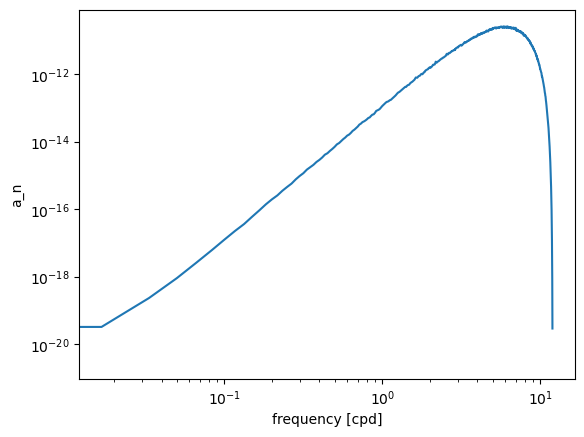

In [182]:
ds.a_n.plot()
plt.xscale("log")
plt.yscale("log")

In [15]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min